# mean reverting algo

# libraries

In [1]:
import pandas as pd
import pandas_datareader as pdr
import numpy as np
import matplotlib.pyplot as plt
import json
import requests
import datetime as dt
from matplotlib import rcParams
rcParams['figure.figsize'] = 12,5

# data import

In [2]:
url = 'https://api.binance.com/api/v3/klines'
params = {'symbol': 'BTCUSDT', 'interval': '1h', 'limit': 1000}
response = requests.get(url, params=params)
req = json.loads(response.text)

data = pd.DataFrame(req, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume',
                                 'close_time', 'qav', 'trades',
                                 'taker_base_vol', 'taker_quote_vol', 'ignored'])

data.drop(columns=['open', 'high', 'low', 'volume', 'close_time', 'qav', 'trades','taker_base_vol', 'taker_quote_vol', 'ignored'], inplace = True)

data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
data.set_index('timestamp', inplace=True)

data['close'] = data['close'].astype(float)

# algo

In [3]:
data

,close
timestamp,
2024-06-30 22:00:00,62901.01
2024-06-30 23:00:00,62772.01
2024-07-01 00:00:00,62931.99
2024-07-01 01:00:00,63640.82
2024-07-01 02:00:00,63435.86
...,...
2024-08-11 09:00:00,61110.00
2024-08-11 10:00:00,61037.63
2024-08-11 11:00:00,60669.15


## sma timeframe

In [4]:
ma = 5
data['returns'] = np.log(data["close"]).diff()
data['ma'] = data['close'].rolling(ma).mean()
data['ratio'] = data['close'] / data['ma']

## percentiles (entries)

In [5]:
percentiles = [7.01293, 44.356, 41.22, 95.66, 95.9]  #94.750435 ultimo, default
p = np.percentile(data['ratio'].dropna(), percentiles)

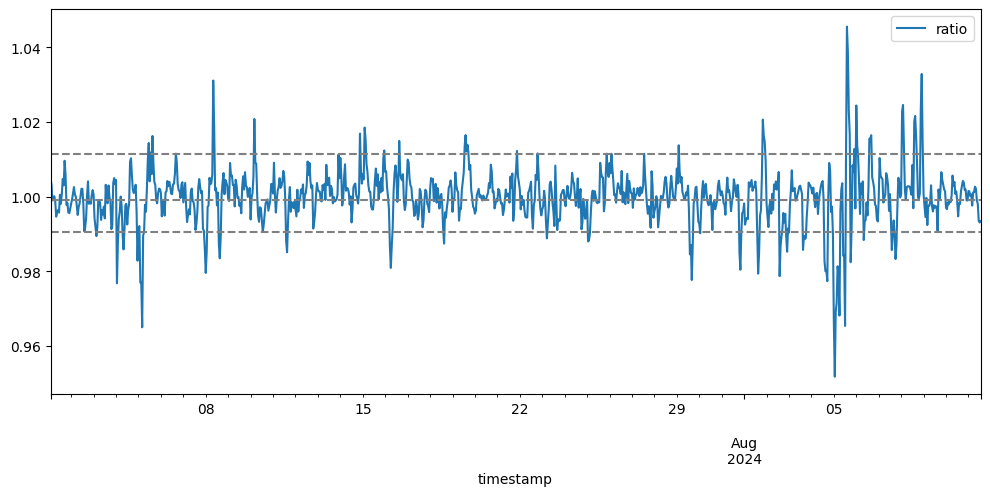

In [6]:
data['ratio'].dropna().plot(legend = True)
plt.axhline(p[0], c= (.5,.5,.5), ls='--')
plt.axhline(p[2], c= (.5,.5,.5), ls='--')
plt.axhline(p[-1], c= (.5,.5,.5), ls='--');

## positions

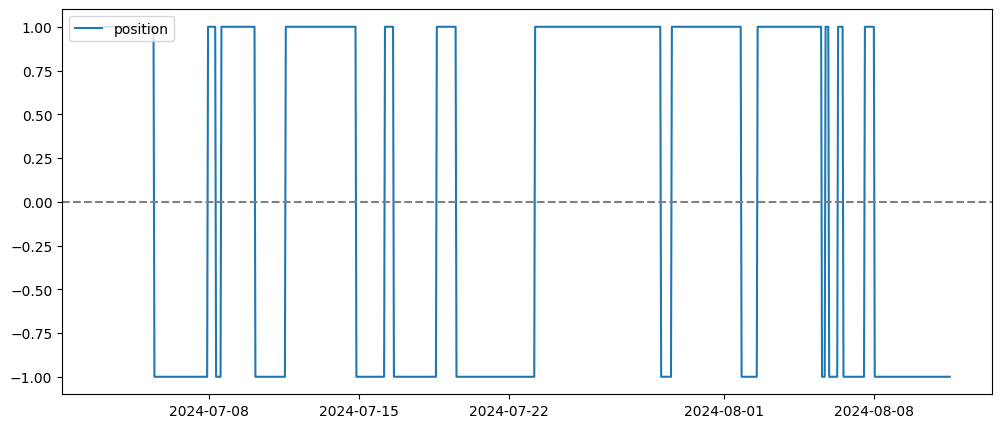

In [7]:
short = p[-1]
long = p[0]
data['position'] = np.where(data.ratio > short, -1, np.nan)
data['position'] = np.where(data.ratio < long, 1, data['position']) 
data['position'] = data['position'].ffill()
data['entry'] =  data.position.diff()

# neutral
neutral_high = 1.154077131171284
neutral_low = 0.9366029469329376

data['position'] = np.where((data.ratio > neutral_high) & (data.position == -1), 0, data['position'])
data['position'] = np.where((data.ratio < neutral_low) & (data.position == 1), 0, data['position'])
data['position'] = data['position'].ffill()

plt.plot(data.position.dropna(), label='position')
plt.axhline(0, color='gray', linestyle='--')
plt.legend(loc = 'upper left')

In [8]:
data['position'][10:]

timestamp
2024-07-01 08:00:00    NaN
2024-07-01 09:00:00    NaN
2024-07-01 10:00:00    NaN
2024-07-01 11:00:00    NaN
2024-07-01 12:00:00    NaN
                      ... 
2024-08-11 09:00:00   -1.0
2024-08-11 10:00:00   -1.0
2024-08-11 11:00:00   -1.0
2024-08-11 12:00:00   -1.0
2024-08-11 13:00:00   -1.0
Name: position, Length: 990, dtype: float64

# ploting entries and performances

## entries

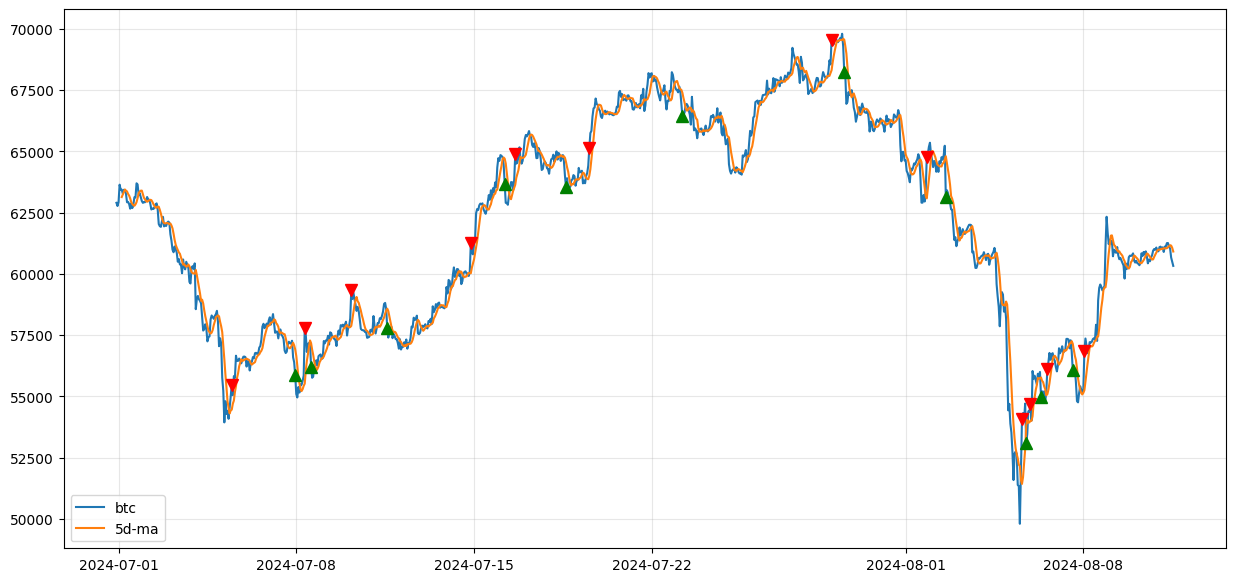

In [9]:
data['5d-ma'] = data['close'].rolling(5).mean().shift()
plt.rcParams['figure.figsize'] = 15, 7
plt.grid(True, alpha = .3)
days = 100000; days = -(days)
plt.plot(data.iloc[days:]['close'], label = 'btc')
plt.plot(data.iloc[days:]['5d-ma'], label = '5d-ma')
plt.plot(data[days:].loc[data.entry == 2].index, data[days:]['close'][data.entry == 2], '^', color = 'g', markersize = 9)
plt.plot(data[days:].loc[data.entry == -2].index, data[days:]['close'][data.entry == -2], 'v', color = 'r', markersize = 9)
plt.legend(loc=3);

# trades

In [10]:
total_trades = len(data[data['entry'] != 0])
print("Total trades:", total_trades)

Total trades: 77


## performances

In [11]:
data['algo_return'] = data['returns'] * data['position'].shift()

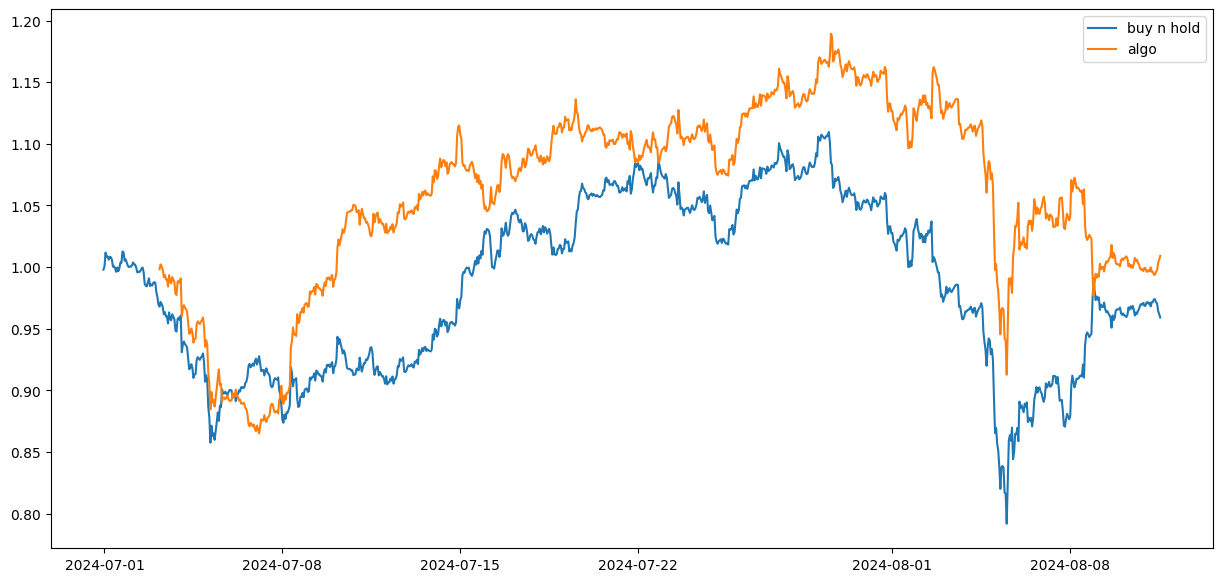

In [12]:
plt.plot(np.exp(data['returns']).dropna().cumprod(), label='buy n hold' )
plt.plot(np.exp(data['algo_return']).dropna().cumprod(), label='algo' )
plt.legend();

# returns

## buy n hold (%)

In [13]:
(np.exp(data['returns']).dropna().cumprod()[-1] -1)*100

C:\Users\cristopher\AppData\Local\Temp\ipykernel_20328\1855609155.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  (np.exp(data['returns']).dropna().cumprod()[-1] -1)*100


-4.090665634780722

## system (%)

In [14]:
(np.exp(data['algo_return']).dropna().cumprod()[-1] -1)*100

C:\Users\cristopher\AppData\Local\Temp\ipykernel_20328\2420040513.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  (np.exp(data['algo_return']).dropna().cumprod()[-1] -1)*100


0.9170929457118726